In [ ]:
import pandas as pd
import numpy as np

# -----------------------------------------
# 1. Compute null stats & preprocessing decisions
# -----------------------------------------
def compute_preprocessing_rules(train):

    # Drop rows where target missing
    train = train.dropna(subset=["spend_category"]).copy()

    # % nulls
    null_pct = (train.isna().sum() / len(train)) * 100

    # Rule 1: rows to drop (<2%)
    rows_to_drop = null_pct[null_pct < 2].index.tolist()

    # Rule 2: columns to drop (>40%)
    columns_to_drop = null_pct[null_pct > 40].index.tolist()
    columns_to_drop.append("arrival_weather")# this feature makes no sense to me
    # Rule 3: categorical imputations chosen manually
    cat_impute_rules = {
        "travel_companions": "Alone",
        "days_booked_before_trip": "61-90"
    }

    return rows_to_drop, columns_to_drop, cat_impute_rules


In [ ]:
def infer_trip_days(row):
    if pd.notna(row["total_trip_days"]):
        return row["total_trip_days"]

    total = row["mainland_stay_nights"] + row["island_stay_nights"]

    if total <= 6:
        return "1-6"
    elif total <= 14:
        return "7-14"
    elif total <= 30:
        return "15-30"
    else:
        return "30+"


In [ ]:
def preprocess_train(train, rows_to_drop, columns_to_drop, cat_impute_rules):

    train = train.copy()

    # Drop rows with target missing
    train = train.dropna(subset=["spend_category"])

    # Drop duplicates
    train = train.drop_duplicates()

    # Drop rows (<2% null)
    for col in rows_to_drop:
        train = train[train[col].notna()]

    # Drop columns (>40% null)
    train = train.drop(columns=columns_to_drop, errors="ignore")

    # Manually chosen imputations
    for col, fill_value in cat_impute_rules.items():
        if col in train.columns:
            train[col] = train[col].fillna(fill_value)

    # Drop arrival_weather
    # if "arrival_weather" in train.columns:
    #     train = train.drop(columns=["arrival_weather"])

    # Infer total_trip_days
    train["total_trip_days"] = train.apply(infer_trip_days, axis=1)

    return train


In [ ]:
def preprocess_test(test, train, rows_to_drop, columns_to_drop, cat_impute_rules):

    test = test.copy()

    # Drop same columns as train
    test = test.drop(columns=columns_to_drop, errors="ignore")

    # Same categorical imputations
    for col, fill_value in cat_impute_rules.items():
        if col in test.columns:
            test[col] = test[col].fillna(fill_value)

    # Columns where train dropped rows (<2%)
    for col in rows_to_drop:
        if col not in test.columns:
            continue

        if train[col].dtype == "object":
            test[col] = test[col].fillna(train[col].mode()[0])
        else:
            test[col] = test[col].fillna(train[col].median())

    # Infer total_trip_days
    test["total_trip_days"] = test.apply(infer_trip_days, axis=1)

    return test


In [ ]:
# Load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Compute rules from train
rows_to_drop, columns_to_drop, cat_impute_rules = compute_preprocessing_rules(train)

# Apply preprocessing
train_clean = preprocess_train(train, rows_to_drop, columns_to_drop, cat_impute_rules)
test_clean = preprocess_test(test, train_clean, rows_to_drop, columns_to_drop, cat_impute_rules)

print(train_clean.isna().sum())
print(test_clean.isna().sum())


trip_id                        0
country                        0
age_group                      0
travel_companions              0
num_females                    0
num_males                      0
main_activity                  0
visit_purpose                  0
is_first_visit                 0
mainland_stay_nights           0
island_stay_nights             0
tour_type                      0
intl_transport_included        0
info_source                    0
accomodation_included          0
food_included                  0
domestic_transport_included    0
sightseeing_included           0
guide_included                 0
insurance_included             0
days_booked_before_trip        0
total_trip_days                0
spend_category                 0
dtype: int64
trip_id                        0
country                        0
age_group                      0
travel_companions              0
num_females                    0
num_males                      0
main_activity                 

['num_females', 'num_males', 'mainland_stay_nights', 'island_stay_nights', 'spend_category']


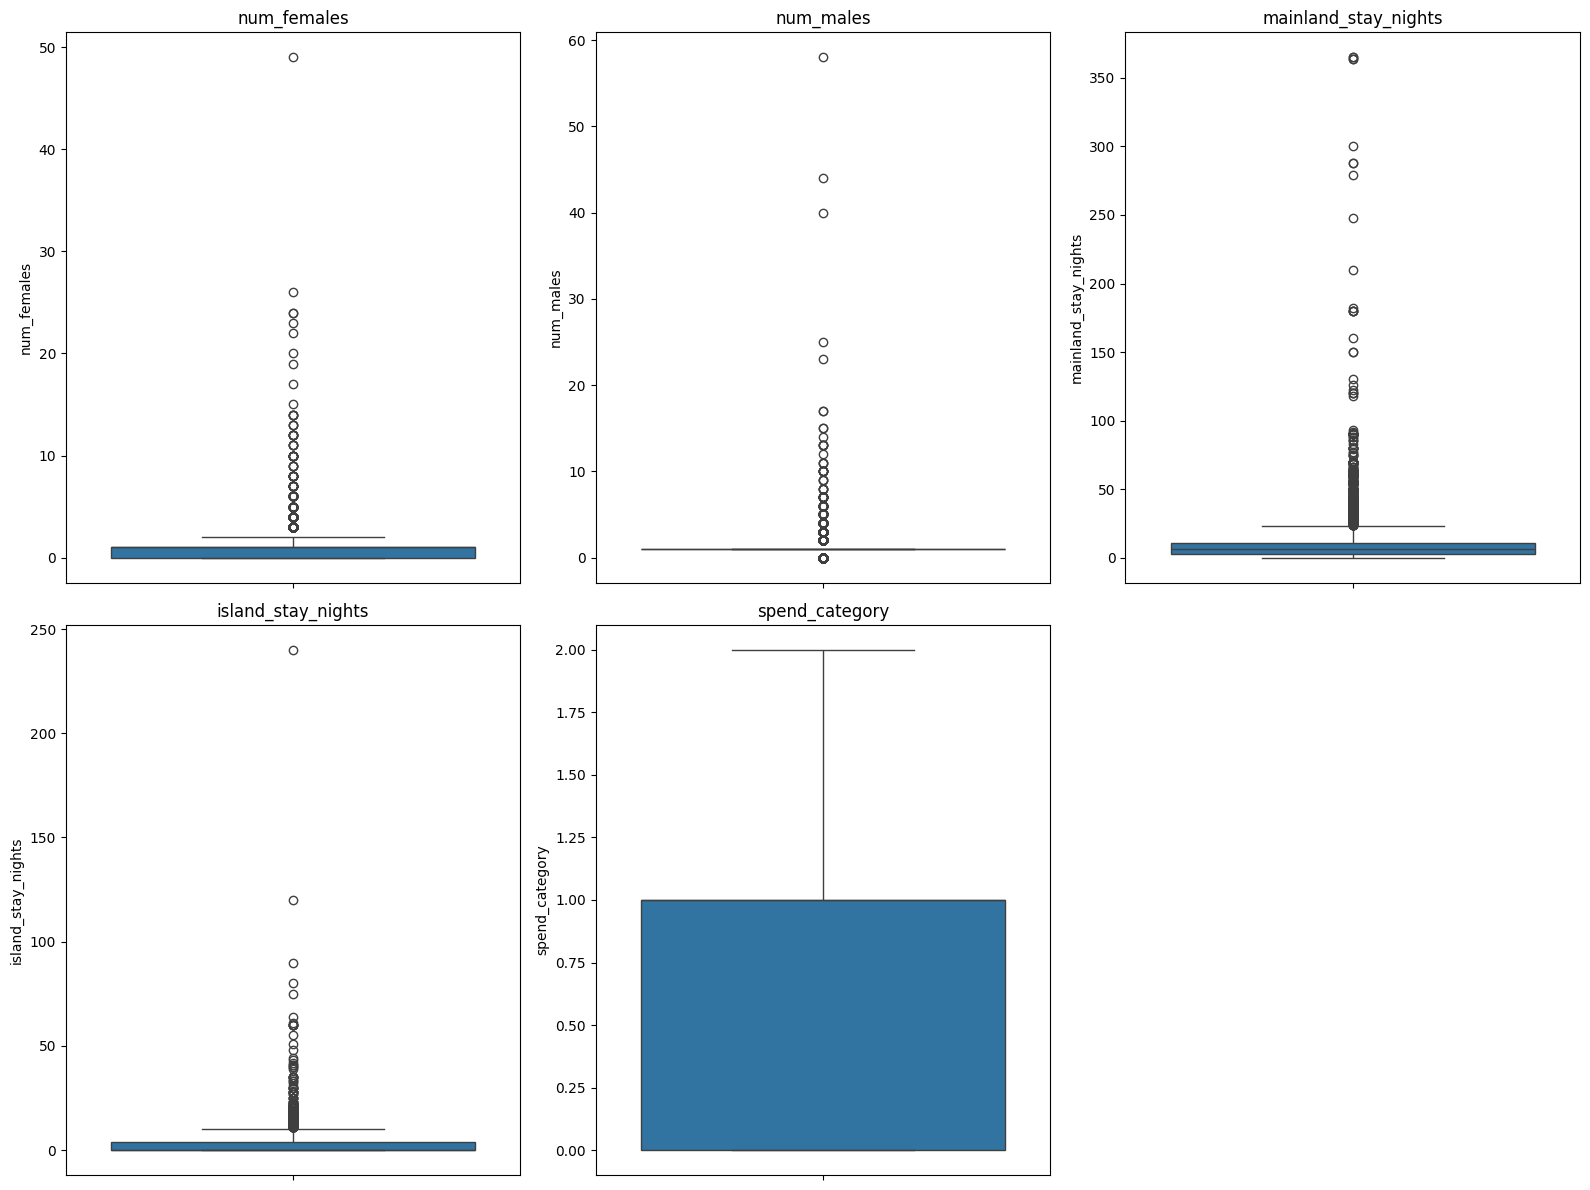

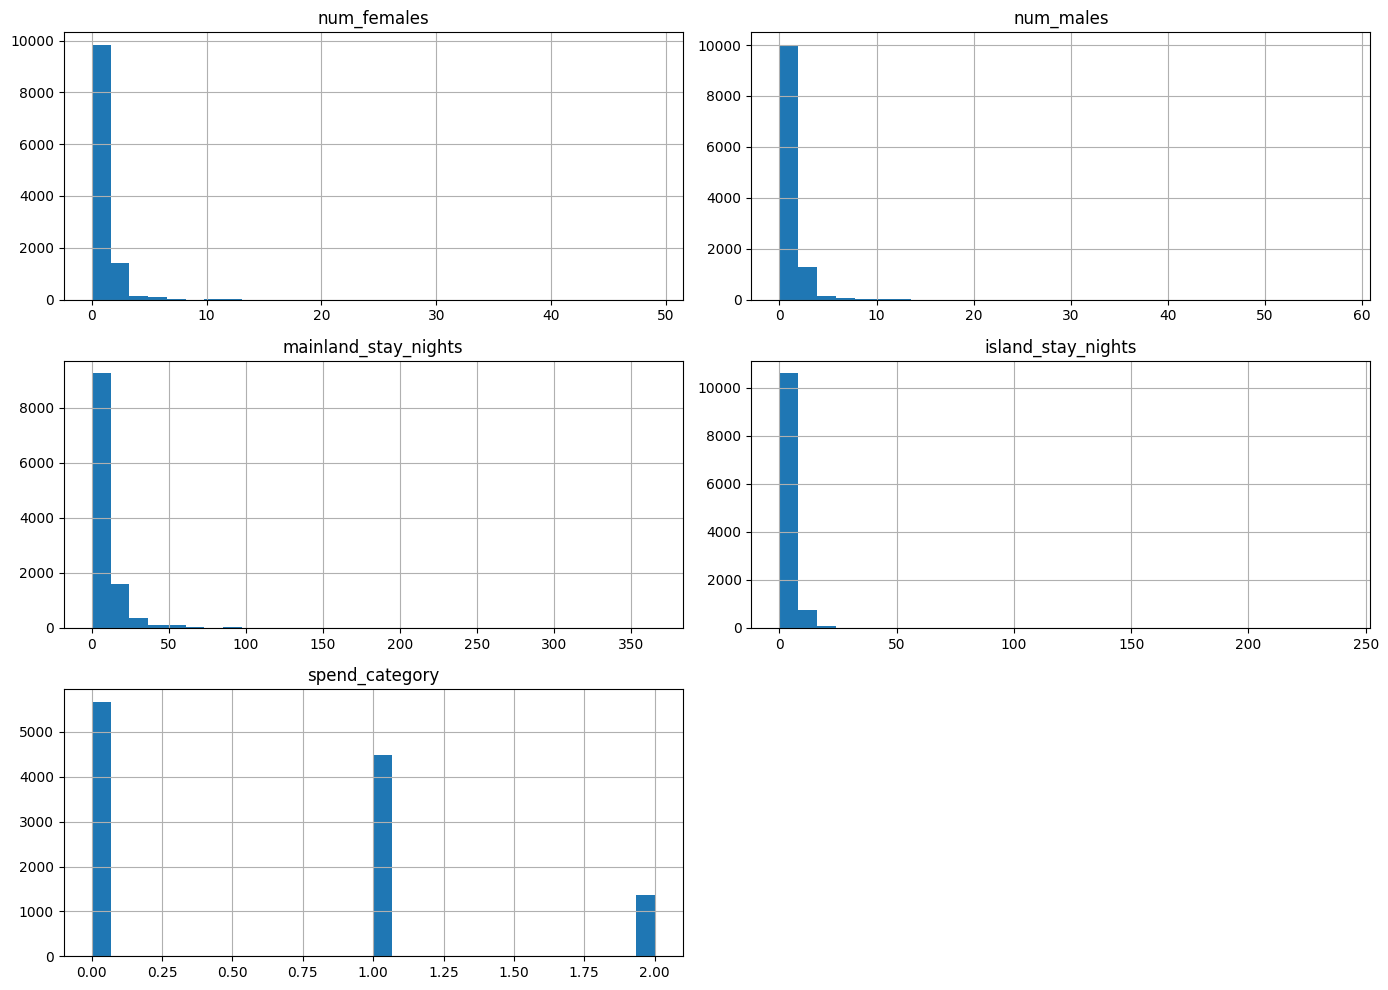

        num_females     num_males  mainland_stay_nights  island_stay_nights  \
count  11505.000000  11505.000000          11505.000000        11505.000000   
mean       0.949066      1.012169              9.206780            2.522555   
std        1.295324      1.273400             14.868802            5.170178   
min        0.000000      0.000000              0.000000            0.000000   
25%        0.000000      1.000000              3.000000            0.000000   
50%        1.000000      1.000000              6.000000            0.000000   
75%        1.000000      1.000000             11.000000            4.000000   
max       49.000000     58.000000            365.000000          240.000000   

       spend_category  
count    11505.000000  
mean         0.625120  
std          0.686026  
min          0.000000  
25%          0.000000  
50%          1.000000  
75%          1.000000  
max          2.000000  


In [ ]:
# ---------------------------------------------------
#  Visualise numeric columns for outliers & skew
# ---------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = train_clean.select_dtypes(include=["int64","float64"]).columns.tolist()
print(num_cols)
# 1. Boxplots (outliers)
plt.figure(figsize=(16, 12))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols)//3 + 1, 3, i)
    sns.boxplot(train_clean[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# 2. Histograms (distribution / skew)
train_clean[num_cols].hist(figsize=(14, 10), bins=30)
plt.tight_layout()
plt.show()

# 3. Summary stats
print(train_clean[num_cols].describe())


In [ ]:
# ---------------------------------------------------
# Outlier clipping (winsorizing hard outliers)
# ---------------------------------------------------

## used domain aware clipping instaed of IQR method
def clip_outliers(df):
    df = df.copy()

    # 1. People counts
    df["num_females"] = df["num_females"].clip(0, 5)
    df["num_males"] = df["num_males"].clip(0, 5)

    # 2. Stays
    df["mainland_stay_nights"] = df["mainland_stay_nights"].clip(0, 30)
    df["island_stay_nights"] = df["island_stay_nights"].clip(0, 21)

    return df

train_clean = clip_outliers(train_clean)
test_clean  = clip_outliers(test_clean)


In [ ]:
X = train_clean.drop(columns=["spend_category", "trip_id"])
y = train_clean["spend_category"]

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler

categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ("num", RobustScaler(), num_cols)
])

# ===============================================================
# Naive Bayes (GaussianNB)
# ===============================================================

from sklearn.naive_bayes import GaussianNB

nb_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("nb", GaussianNB())
])

nb_pipeline.fit(X_train, y_train)
nb_pred = nb_pipeline.predict(X_val)

print("Naive Bayes Val Acc:", accuracy_score(y_val, nb_pred))

nb_test_pred = nb_pipeline.predict(test_clean)

pd.DataFrame({
    "trip_id": test["trip_id"],
    "spend_category": nb_test_pred
}).to_csv("nb_submission.csv", index=False)


Neural Network Val Acc: 0.7709691438504997


In [ ]:

nb_pipeline.fit(X, y)
nb_pred = nb_pipeline.predict(X_val)

print("Naive Bayes Val Acc:", accuracy_score(y_val, nb_pred))

nb_test_pred = nb_pipeline.predict(test_clean)

pd.DataFrame({
    "trip_id": test["trip_id"],
    "spend_category": nb_test_pred
}).to_csv("nb_submission.csv", index=False)

Neural Network Val Acc: 0.7861799217731421
